<a href="https://colab.research.google.com/github/nithishareddy/CannyEdgeDetection/blob/main/CV_PA1_Nithisha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

jpg files found: ['41004.jpg', '227040.jpg', '302003.jpg']


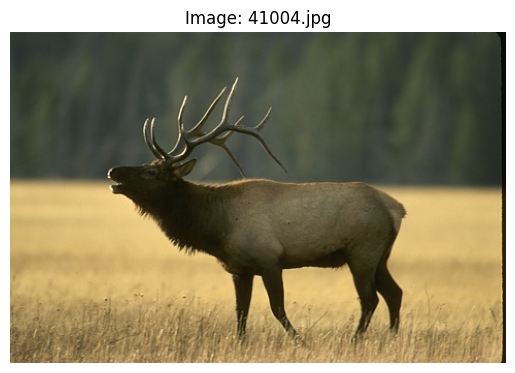

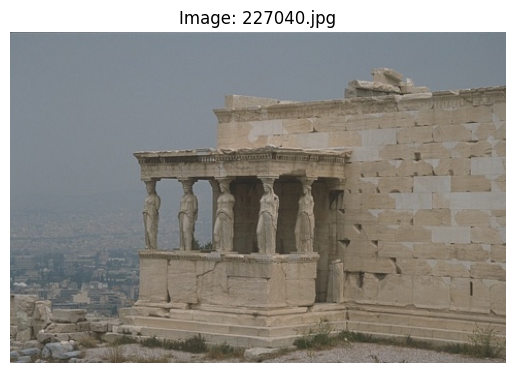

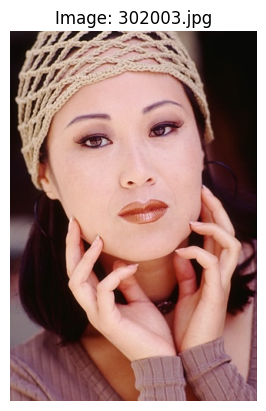

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the sample_data folder path
sample_data_path = '/content/'

# List all PNG files in the sample_data folder
jpg_files = [f for f in os.listdir(sample_data_path) if f.endswith('.jpg')]

# Check if there are PNG files
if not jpg_files:
    print("No jpg files found in the sample_data folder.")
else:
    print("jpg files found:", jpg_files)

# Load and display PNG files using PIL
for img_file in jpg_files:
    img_path = os.path.join(sample_data_path, img_file)
    img = Image.open(img_path)  # Open the image file
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.title(f"Image: {img_file}")
    plt.show()  # Display the image


In [9]:
import cv2
images = []
for file in jpg_files:
    image_path = os.path.join(sample_data_path, file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # You can change IMREAD_GRAYSCALE to IMREAD_COLOR if needed
    if image is not None:
        images.append(image)
    else:
        print(f"Error reading {image_path}")

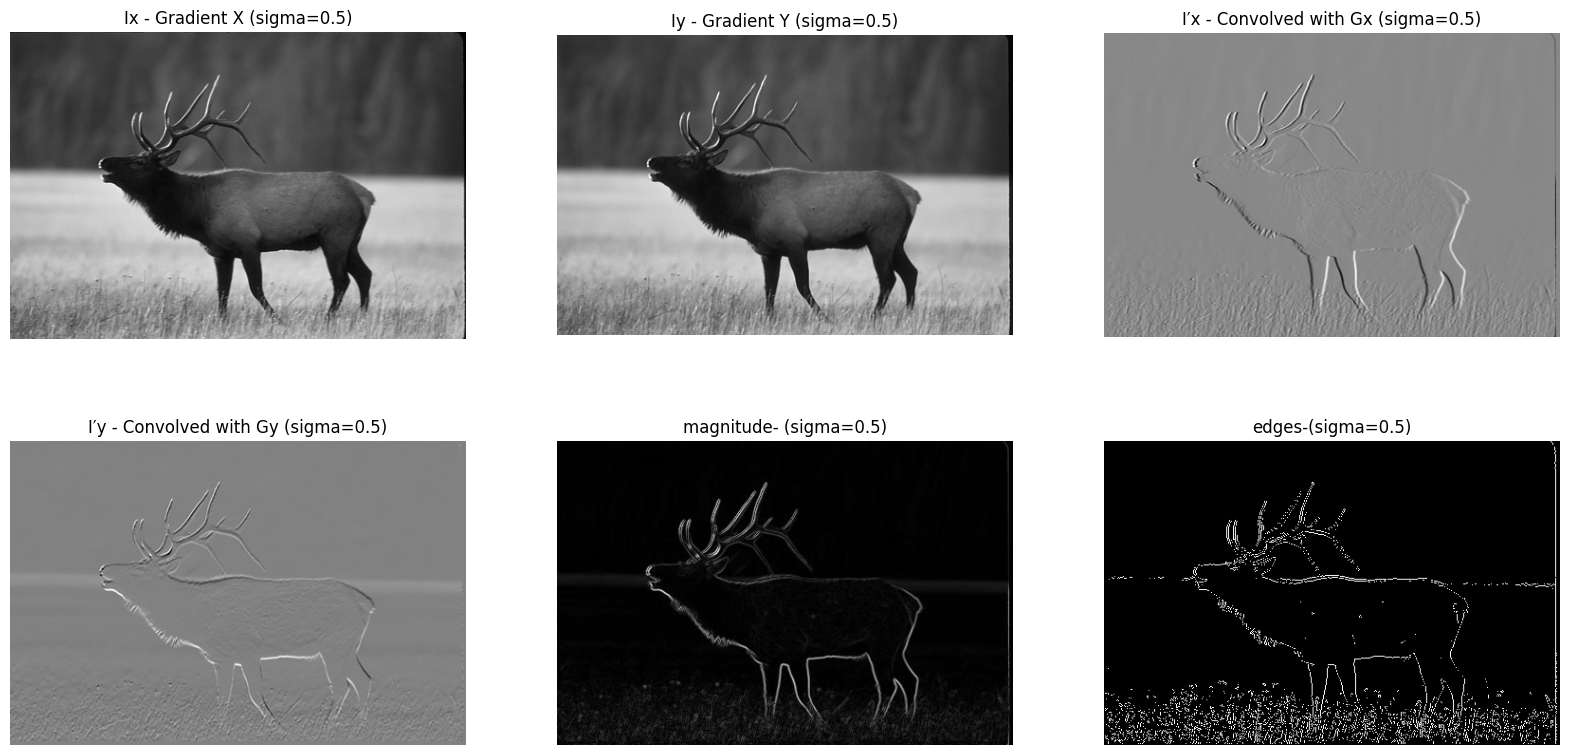

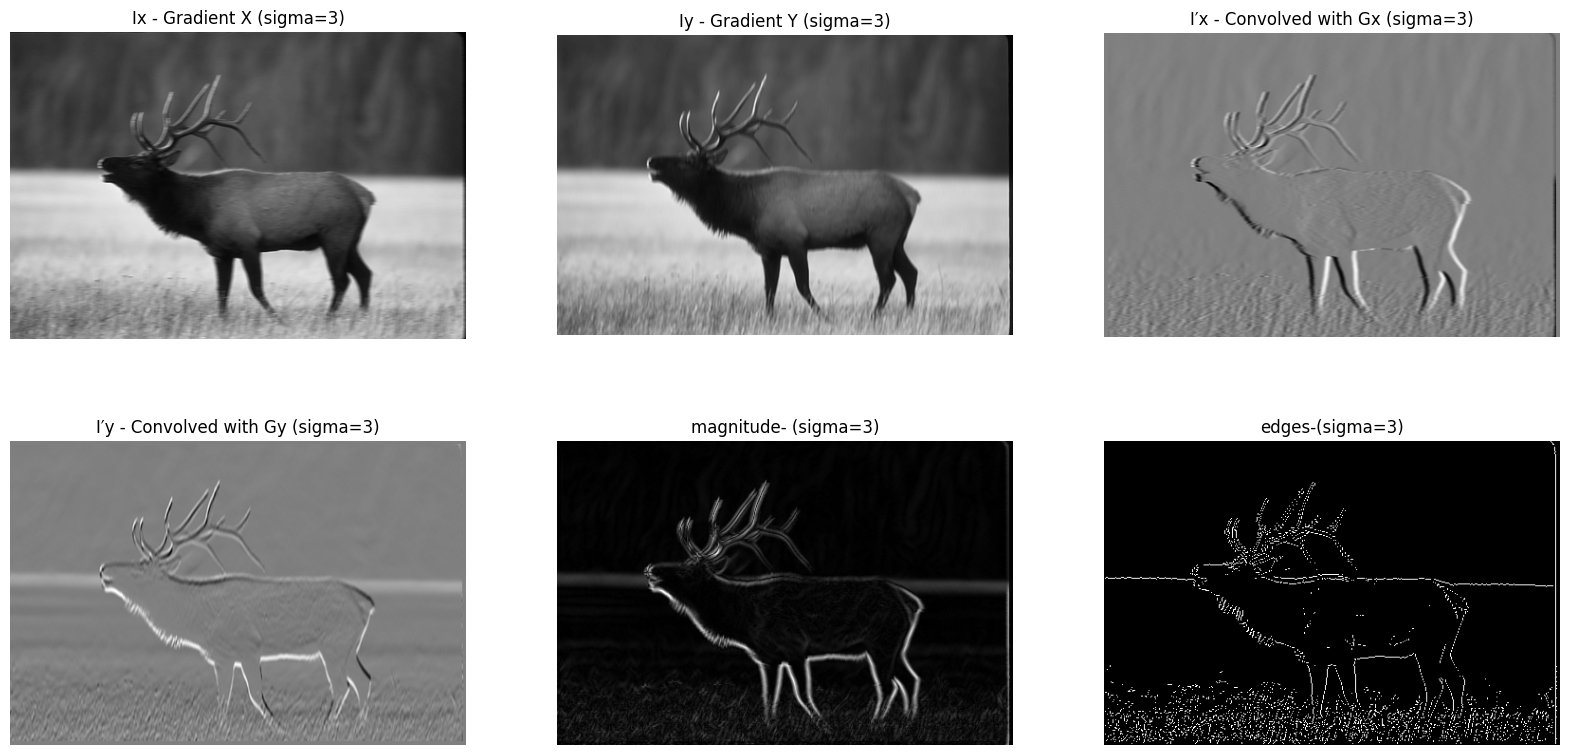

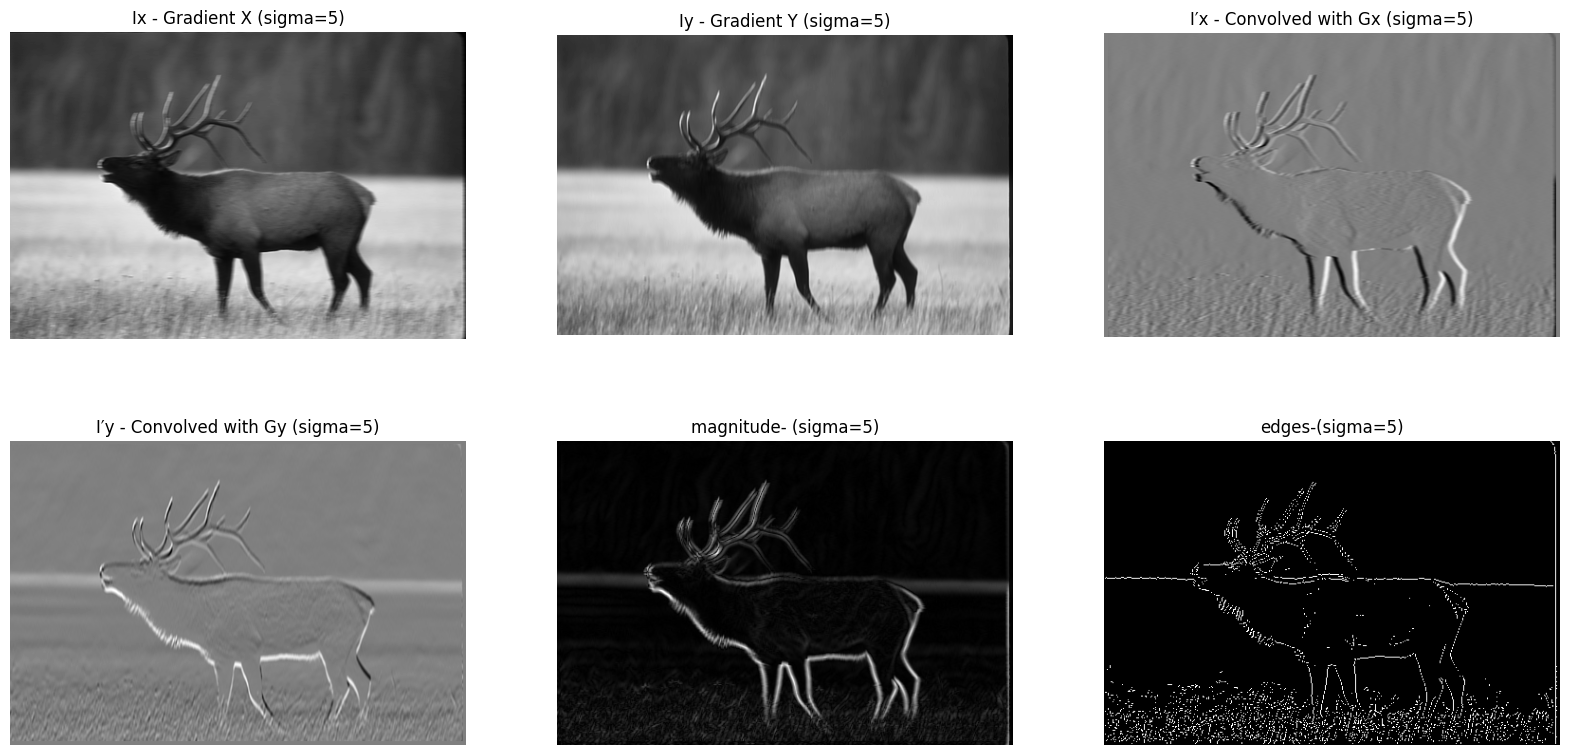

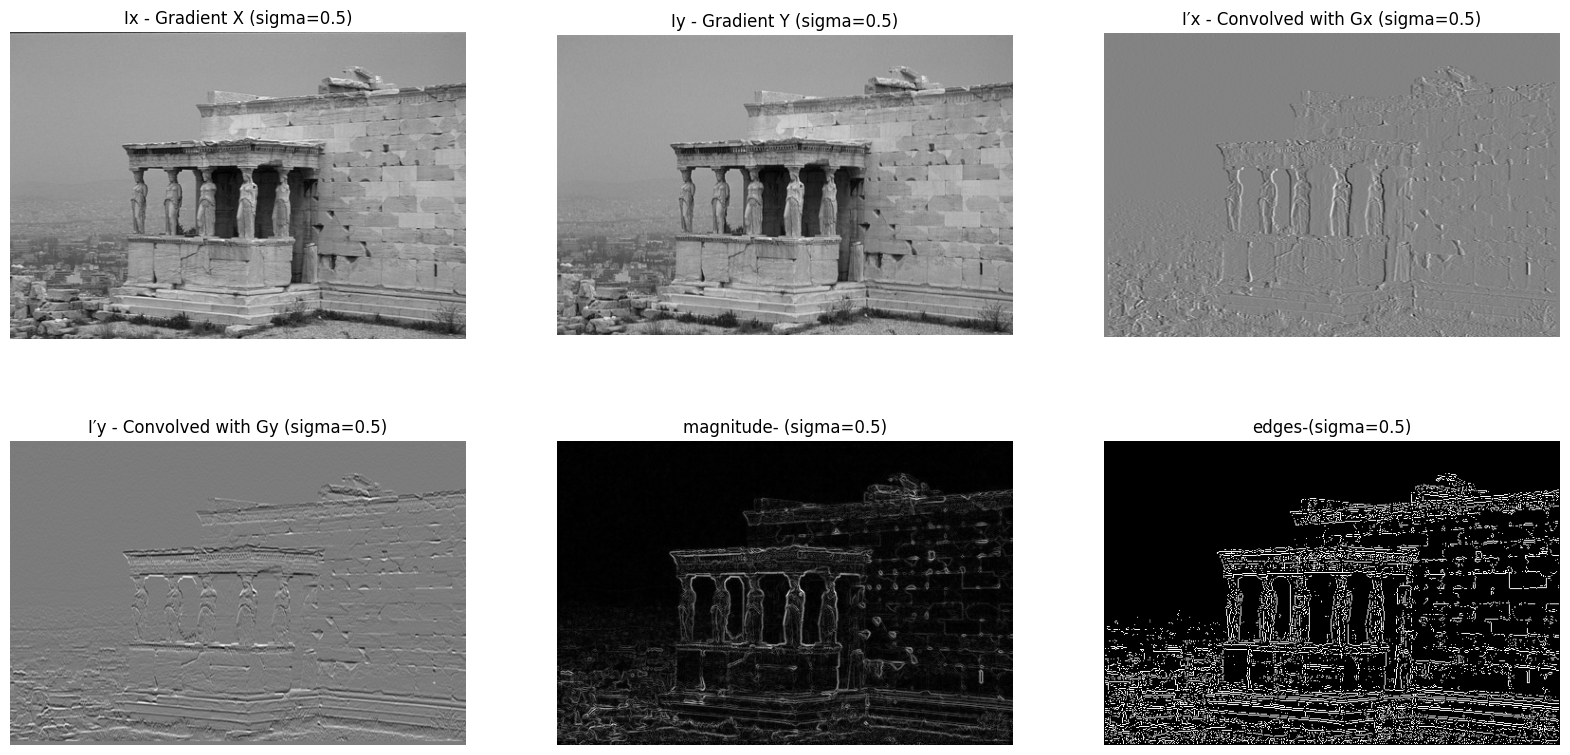

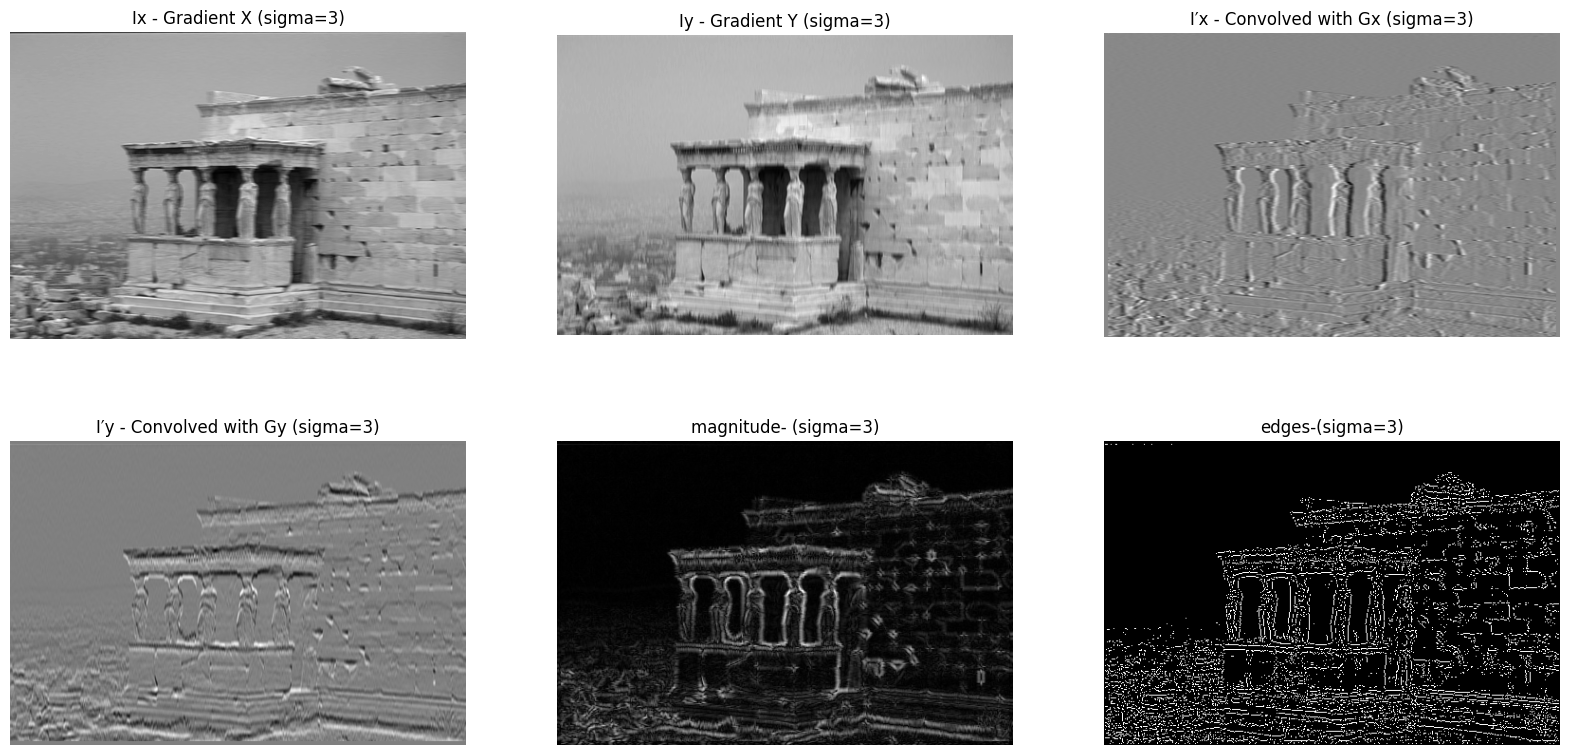

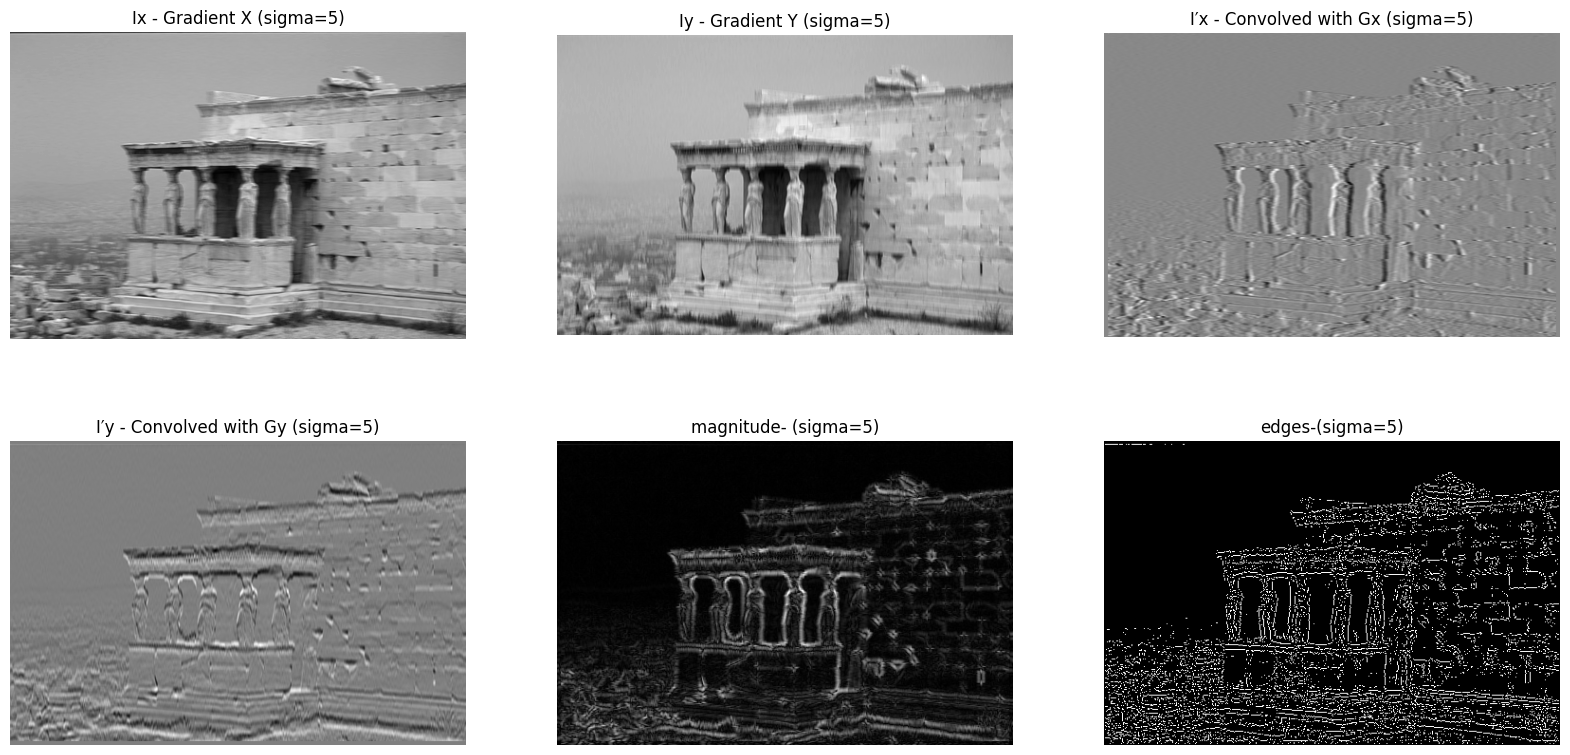

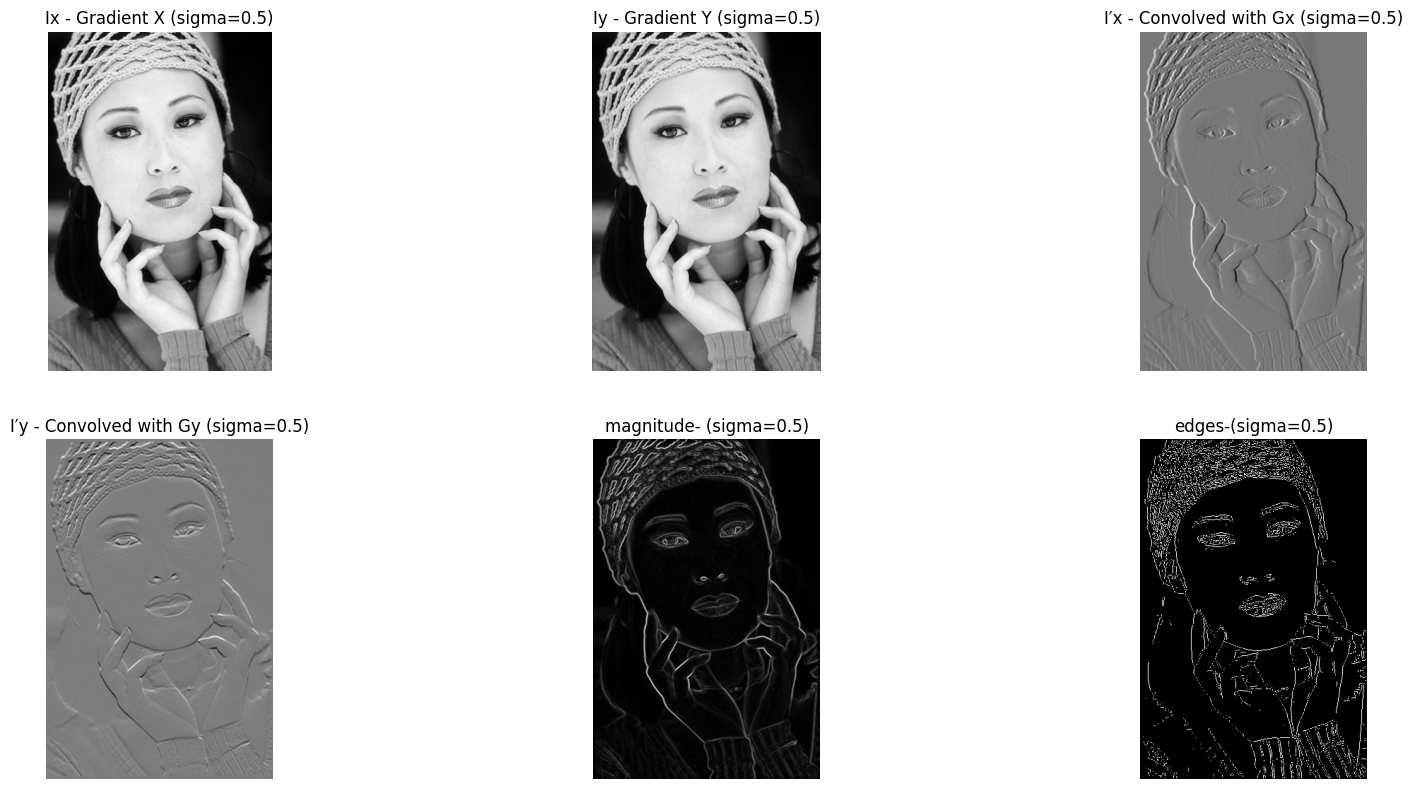

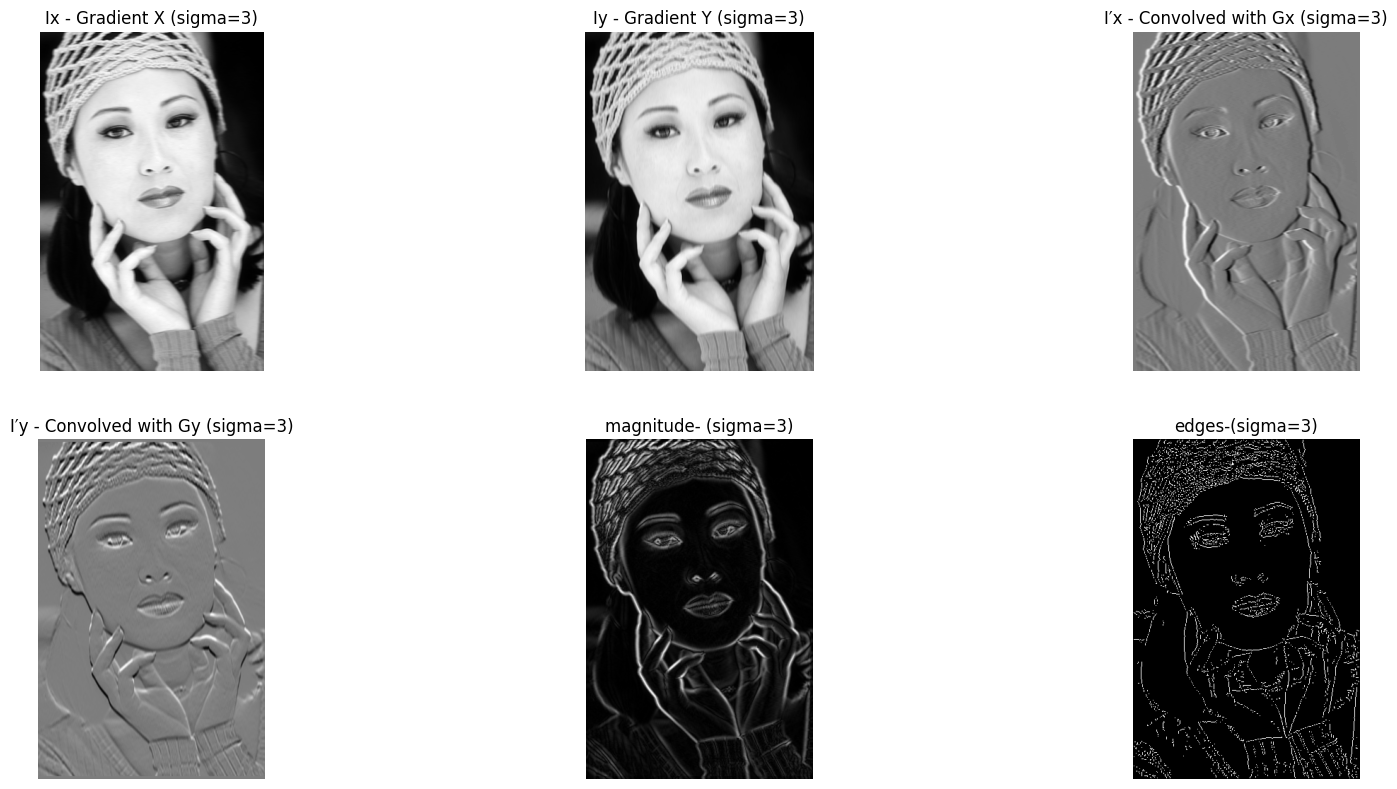

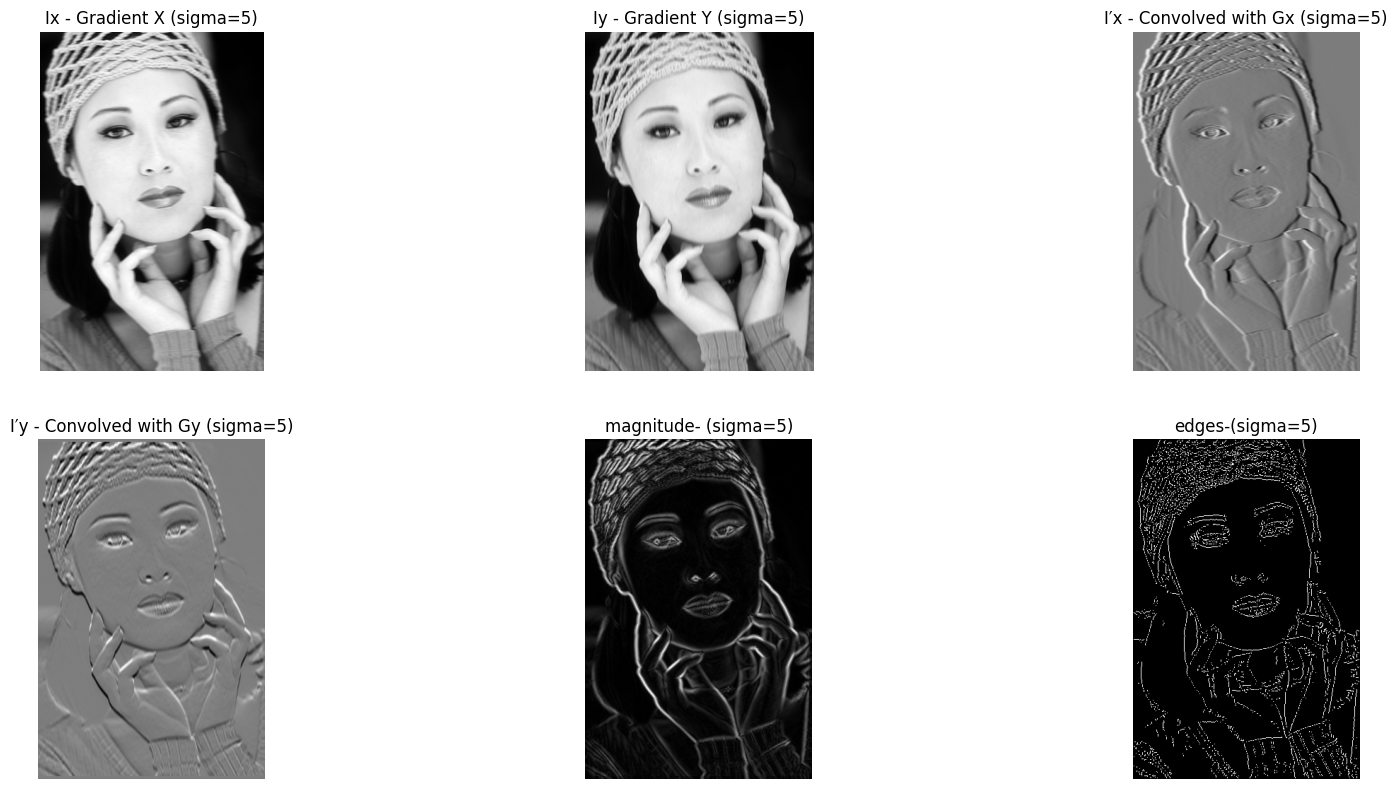

In [10]:
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
import requests
import numpy as np
from scipy.ndimage import gaussian_filter, sobel, label



def gaussian_kernel_1d(sigma, sobelKernelArr):
    #create 1D gaussian kernel
    kernel_range = np.array(sobelKernelArr)
    kernel = np.exp(-0.5 * (kernel_range / sigma)**2)
    constant = 1 / ((math.sqrt(2 * math.pi)))
    kernel = constant / sigma * kernel
    return kernel

def gaussian_derivative_1d(sigma, sobelKernelArr):
    #create first derivative gaussian kernel
    kernel_range = np.array(sobelKernelArr) #sobel kernel
    constant = 1 / ((math.sqrt(2 * math.pi)))
    kernel =  np.exp(-0.5 * (kernel_range / sigma)**2)
    kernel = -kernel_range * constant / (sigma**3) * kernel
    return kernel


def convolveFunctionT(I, gaussKernel):
  #perform convolution with 1D guassian kernel
    resultOfConvolution = []
    I = np.asarray(I)
    gaussKernel = np.flip(gaussKernel)
    gaussKernel = np.asarray(gaussKernel)
    for row in I:
        newRow = []
        for i in range(0, len(row) - len(gaussKernel) + 1):
            sumati = 0
            for j in range(len(gaussKernel)):
                sumati = sumati + row[i+j]*gaussKernel[j]
            newRow.append(sumati)
        resultOfConvolution.append(newRow)
    return np.array(resultOfConvolution)

def compute_magnitude(I_prime_x, I_prime_y):
    #Compute the magnitude of the edge response.
    magnitude = np.sqrt(I_prime_x**2 + I_prime_y**2)
    return magnitude

def padImages(I_prime_x,I_prime_y,I):
    #pad zeroes to convoluted images
    Irows, Icols = I.shape
    IprXrows, IprXcols = I_prime_x.shape
    IprYrows, IprYcols = I_prime_y.shape


    # pad Ix' with zeroes
    for i in range(int((Icols - IprXcols)/2)):
        xPadded = [[0] * (Irows)]
        I_prime_x = np.append(I_prime_x, np.transpose(xPadded), axis=1)
        I_prime_x = np.insert(I_prime_x, 0, xPadded,axis=1)


    #pad Iy' with zeroes
    for i in range(int((Irows - IprYrows)/2)):
        yPadded = [[0] * (Icols)]
        I_prime_y = np.append(I_prime_y, yPadded, axis=0)
        I_prime_y = np.insert(I_prime_y, 0, yPadded, axis=0)
    return I_prime_x,I_prime_y


def non_maximum_suppression(M, theta):
    #Remove False positive edges using non max suppression
    rows, cols = M.shape
    suppressed = np.zeros_like(M)

    # Angle adjustments for direction
    angle = theta * 180 / np.pi
    angle[angle < 0] += 180

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            q, r = 255, 255  # Defaults to high values to ensure suppression
            # Angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = M[i, j + 1]
                r = M[i, j - 1]
            # Angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = M[i + 1, j - 1]
                r = M[i - 1, j + 1]
            # Angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = M[i + 1, j]
                r = M[i - 1, j]
            # Angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = M[i - 1, j - 1]
                r = M[i + 1, j + 1]

            if M[i, j] >= q and M[i, j] >= r:
                suppressed[i, j] = M[i, j]
            else:
                suppressed[i, j] = 0

    return suppressed

def hysteresis_thresholding(M):
    #apply hysterisis thresholding
    high_thresh = np.max(M) * 0.09
    low_thresh = np.max(M) * 0.01

    # Create binary image based on thresholds
    strong_edges = M >= high_thresh
    weak_edges = (M >= low_thresh) & (M < high_thresh)

    # Include strong edges
    result = np.zeros_like(M)
    result[strong_edges] = 1

    # Compute connected components for weak edges using scipy label fn
    labeled_array, num_features = label(weak_edges)

    # Include weak edges connected to strong edges
    for i in range(1, num_features + 1):
        if np.any(result[labeled_array == i]):
            result[labeled_array == i] = 1

    return result


project_directory = os.getcwd()

sigmas = [0.5,3,5]

#Edge detection for every image listed in 'images' array
for i, I in enumerate(images):
    #plt.figure(figsize=(20, 15))
    for j, sigma in enumerate(sigmas):
        plt.figure(figsize=(20, 15))

        sobelKernelArr = [-2,-1,0,1,2] #central difference mask

        # Step2 : Create Gaussian kernel
        G = gaussian_kernel_1d(sigma, sobelKernelArr)

        # Convolve the image with the gaussian kernels for smoothing
        Ix = convolveFunctionT(I, G)
        Iy = convolveFunctionT(I.T, G).T

        #Step 3: create guassian derivatives Gx,Gy
        Gx = gaussian_derivative_1d(sigma, sobelKernelArr)
        Gy = Gx.T

        # Step 4: Further convolution with the derivative kernels to get I′x and I′y
        I_prime_x = convolveFunctionT(Ix, Gx)
        I_prime_y = convolveFunctionT(Iy.T, Gy).T

        # pad the images
        I_prime_x,I_prime_y = padImages(I_prime_x,I_prime_y,I)

        # Step 5: Compute the magnitude of the edge response
        magnitude = compute_magnitude(I_prime_x, I_prime_y)

        theta = np.arctan2(I_prime_y, I_prime_x)   # Gradient direction (angle)

        #Step 6: Non max suppression algorithm
        nonMaxSupp = non_maximum_suppression(magnitude,theta)

        #Step 7: apply hysteris thresholding
        edges = hysteresis_thresholding(nonMaxSupp)

        # Display the result for i'th image
        output_path = os.path.join(project_directory, 'Img_'+str(i)+'_Sig_'+str(sigma)+'.jpg')

        plt.subplot(3, 3, 1)
        plt.imshow(Ix, cmap='gray')
        plt.title(f'Ix - Gradient X (sigma={sigma})')
        plt.axis('off')

        plt.subplot(3, 3, 2)
        plt.imshow(Iy, cmap='gray')
        plt.title(f'Iy - Gradient Y (sigma={sigma})')
        plt.axis('off')

        plt.subplot(3, 3, 3)
        plt.imshow(I_prime_x, cmap='gray')
        plt.title(f'I′x - Convolved with Gx (sigma={sigma})')
        plt.axis('off')

        plt.subplot(3, 3, 4)
        plt.imshow(I_prime_y, cmap='gray')
        plt.title(f'I′y - Convolved with Gy (sigma={sigma})')
        plt.axis('off')

        plt.subplot(3, 3, 5)
        plt.imshow(magnitude, cmap='gray')
        plt.title(f'magnitude- (sigma={sigma})')
        plt.axis('off')

        plt.subplot(3, 3, 6)
        plt.imshow(edges, cmap='gray')
        plt.title(f'edges-(sigma={sigma})')
        plt.axis('off')


        plt.show()
        #print(f'saving result in Img_{str(i)}_Sig_{str(sigma)}.jpg')
        #plt.savefig(output_path)

